In [1]:
import cv2
import imutils
import numpy as np
from imutils import paths
from matplotlib import pyplot as plt

## 1. Import image and convert it to grayscale

In [2]:
image = cv2.imread(
    "../data/raw/118.jpg"
)  # charge le fichier dans une matrice de pixels couleur
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

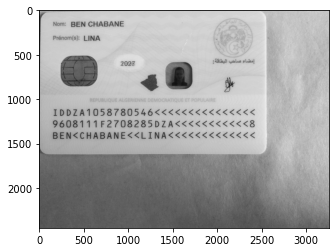

In [3]:
plt.imshow(image, cmap="gray")
plt.show()

## 2. Gaussian Blur

* change the size of the image (image height) to 600, and apply a low-pass gaussian filter using a kernel (3, 3)
* Should specify $\sigma_x$ and $\sigma_y$. If $\sigma_x = 0$ then  $\sigma_x = \sigma_y = 0$, then the deviations along $x$ and $y$ are computed automatically
* The goal of this step is reduce the high frequency noise

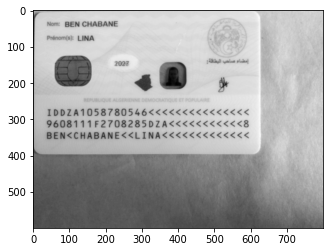

In [4]:
image = imutils.resize(image, height=600)
gray = cv2.GaussianBlur(image, (3, 3), 0)
plt.imshow(gray, cmap="gray")
plt.show()

## 3. Black Hat

* **Black Hat:** is the difference between the closing of the input image and input image. 
* **Closing** is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object. 
* This operation is used to detect MRZ (machine readable zone), a black text on a white background.
* Kernel size: (13, 5)

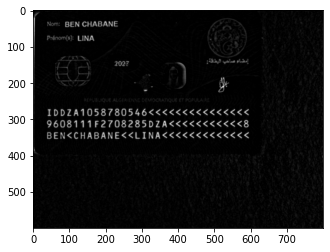

In [5]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
plt.imshow(blackhat, cmap="gray")
plt.show()

## 4. Compute the gradient

* We compute the gradient along the $x$ axis, to detect the zones that contain a fast vertical variations (text regions)
* Scale the resulting image to $[0, 255]$ using the max-min scaler

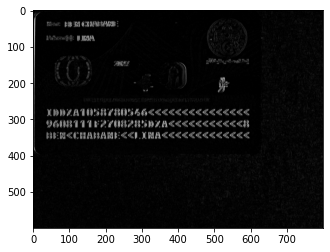

In [6]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
plt.imshow(gradX, cmap="gray")
plt.show()

## 5. Morphology operations

* Closing operation to close text regions
* Kernel size = (13, 5)
* Thresholding

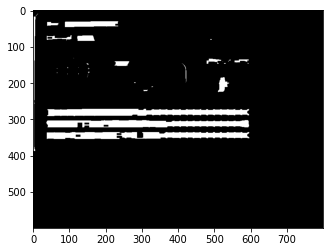

In [7]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh, cmap="gray")
plt.show()

* Another operation of closing using a square kernel $(25, 25)$, to close the different lines of text
* A series of erosion to detach different connected objects and eliminate a small white noises
* During the closing operation, the ROI may be connected to boundaries, so zeros the regions around the edges of the image

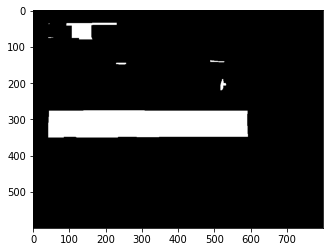

In [8]:
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=4)
p = int(image.shape[1] * 0.05)
thresh[:, 0:p] = 0
thresh[:, image.shape[1] - p :] = 0

plt.imshow(thresh, cmap="gray")
plt.show()

## 6. Find contours

* Find the ROI by defining $(x, y, w, h)$
* (𝑥, 𝑦) is the top left coordinate of the rectangle and (𝑤, ℎ) is its width and height

In [9]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    # Calculer le cadre du contour
    (x, y, w, h) = cv2.boundingRect(c)
    # Calculer un ratio de la largeur par rapport à la hauteur
    ar = w / float(h)
    if ar > 4:
        # pad the bounding box
        pX = int((x + w) * 0.05)
        pY = int((y + h) * 0.05)
        (x, y) = (x - pX, y - pY)
        (w, h) = (w + (pX * 2), h + (pY * 2))
        roi = image[y : y + h, x : x + w]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        break

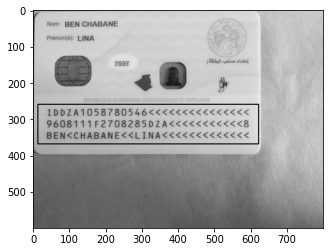

In [10]:
plt.imshow(image, cmap="gray")
plt.show()

## 7. Get the ROI

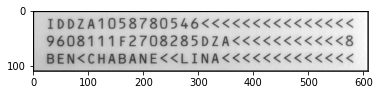

In [11]:
plt.imshow(roi, cmap="gray")
plt.show()
M, N = roi.shape
roi[0:1, :] = 255
roi[M - 1 : M, :] = 255
roi[:, 0:1] = 255
roi[:, N - 1 : N] = 255

## 8. Straighten the ROI

In [12]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    # gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(thresh, kernel, iterations=3)

    # Find all contours
    contours, hierarchy = cv2.findContours(
        dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    # allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours]
    # angle = sum(allContourAngles) / len(allContourAngles)
    if angle < -45:
        angle = 90 + angle
    if angle > 45:
        angle = 90 - angle
        angle = -1 * angle
    return -1.0 * angle


def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(
        newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    return newImage


# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

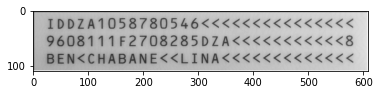

In [13]:
roi = deskew(roi)
plt.imshow(roi, cmap="gray")
plt.show()

## 9. Thresholding

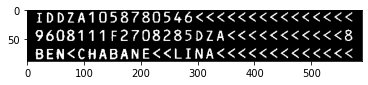

In [14]:
(thresh, roi_th) = cv2.threshold(roi, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
M, N = roi_th.shape
M, N = roi.shape
s = 10
roi_th = roi_th[s : M - s, s : N - s]
roi = roi[s : M - s, s : N - s]
plt.imshow(roi_th, cmap="gray")
plt.show()

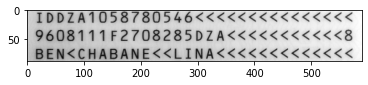

In [15]:
plt.imshow(roi, cmap="gray")
plt.show()

## 10. Separate the lines

In [16]:
def separate_lines(imageB, imageG):
    M, N = imageB.shape
    lines = []
    for i in range(0, M):
        if np.all(imageB[i, :] == 0):
            lines.append(i)
    l = []
    cmp = 0
    while cmp < len(lines) - 1:
        D = lines[cmp + 1] - lines[cmp]
        if D > 5:
            l.append(lines[cmp])
            l.append(lines[cmp + 1])
        cmp += 1

    l1 = imageG[l[0] : l[1] + 3, :]
    l2 = imageG[l[2] - 3 : l[3] + 3, :]
    l3 = imageG[l[4] - 3 : l[5] + 3, :]
    images = [l1, l2, l3]
    l1 = imageB[l[0] - 3 : l[1] + 3, :]
    l2 = imageB[l[2] - 3 : l[3] + 3, :]
    l3 = imageB[l[4] - 3 : l[5] + 3, :]

    images.append(l1)
    images.append(l2)
    images.append(l3)
    return images

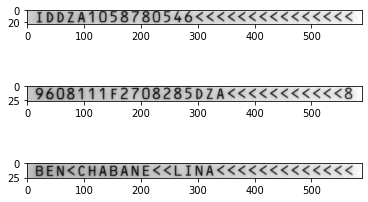

In [17]:
images = separate_lines(roi_th, roi)
for i in range(3):
    position = 310 + i + 1
    plt.subplot(position)
    plt.imshow(images[i], cmap="gray")
plt.show()

## 11. Separate characters

In [18]:
def separate_characters(imageB, imageG):
    M, N = imageB.shape
    lines = [0]
    for i in range(0, N):
        if np.all(imageB[:, i] == 0):
            lines.append(i)
    l = []
    cmp = 0
    while cmp < len(lines) - 1:
        D = lines[cmp + 1] - lines[cmp]
        if D > 1:
            l.append(lines[cmp])
            l.append(lines[cmp + 1])
        cmp += 1
    if len(l) < 60:
        l.append(N)
        l.append(N)
    if len(l) > 60:
        l = l[:60]
    characters = []
    characters.append(imageG[:, 0 : l[1] + 5])
    cmp = 2
    while cmp < len(l) - 3:
        characters.append(imageG[:, l[cmp] - 5 : l[cmp + 1] + 5])
        cmp += 2
    characters.append(imageG[:, l[-3] :])
    return characters

In [19]:
for i in range(0, 3):
    characters = separate_characters(images[i + 3], images[i])
    print(len(characters))
    print("---")

IndexError: list index out of range

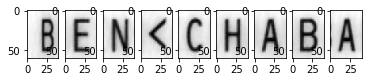

In [20]:
lG = images[2]
lB = images[5]
dim = (40, 60)
characters = separate_characters(lB, lG)
for i in range(9):
    position = 190 + i + 1
    plt.subplot(position)
    c = characters[i]
    c = cv2.resize(c, dim, interpolation=cv2.INTER_AREA)
    plt.imshow(c, cmap="gray")
plt.show()